## Training on 150 epochs


First we have to make all the imports and load the dataset.


In [3]:
from model_evaluation import fit_and_save_model, visualize_performance
import numpy as np
import warnings
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from preprocessing import get_train_test_sets

x_train, x_validate, x_test, y_train, y_validate, y_test = get_train_test_sets()

warnings.filterwarnings("ignore")
IMAGE_SHAPE = (28, 28, 1)

This is the final model, which we chose in the previous notebook


In [2]:
# Define model architecture
final_model = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=IMAGE_SHAPE),
        MaxPooling2D(pool_size=2),
        Dropout(0.25),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPooling2D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

2024-05-25 19:11:28.256272: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We can now train it for longer (150 epochs) to get the highest possible performance.


In [3]:
# Train for 150 epochs
history = fit_and_save_model(
    final_model, "final_model", x_train, y_train, x_validate, y_validate, num_epochs=200
)

2024-05-25 19:34:42.300208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,13,13,32]
	 [[{{node inputs}}]]
2024-05-25 19:34:42.308163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,5,5,64]
	 [[{{node inputs}}]]
2024-05-25 19:34:42.566791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,13,13,32]
	 [[{{node inputs}}]]
202

INFO:tensorflow:Assets written to: ../models/final_model.model/assets


INFO:tensorflow:Assets written to: ../models/final_model.model/assets


## Performance on validation and test set


Let's visualize the performance in the validation set, like we have done for all the models.


Final accuracy:  0.9589
Final validation accuracy:  0.9204


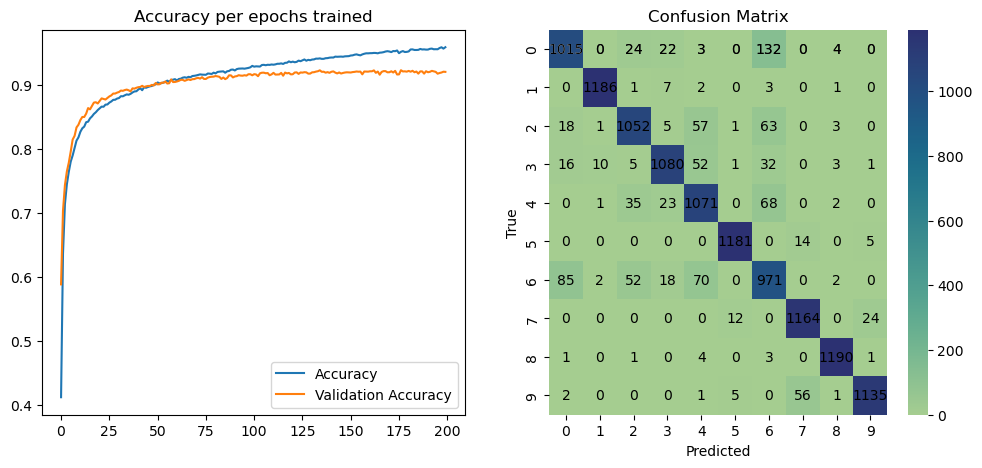

In [4]:
visualize_performance(history, "final_model", x_validate, y_validate)

This is the final model, therefore we can finally use the test set to estimate the true out
of sample error.


Let's compute the predictions for the test set


In [4]:
from tensorflow.keras.saving import load_model

model = load_model("../models/final_model.model")

# Compute predictions for the test set
y_pred_prob = model.predict(x_test, verbose=0)
y_predicted = np.argmax(y_pred_prob, axis=1)
y_true = y_test

Then the accuracy is


In [5]:
from sklearn.metrics import accuracy_score

print(100 * accuracy_score(y_true, y_predicted), "%")

92.57 %


This is a very good performance, specially considering that we estimated human performance at
around 94% in the EDA.


Micro-averaged One-vs-Rest ROC AUC score:
0.9973


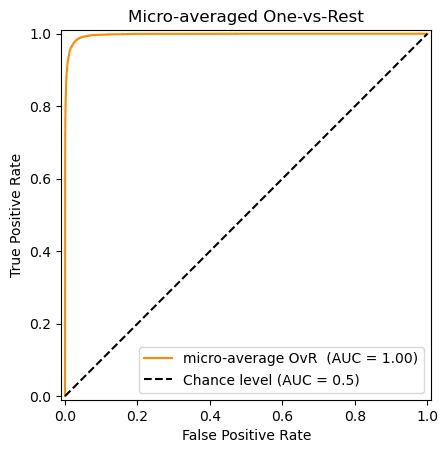

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_pred_prob.ravel(),
    name="micro-average OvR ",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest",
)

from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.4f}")

The micro average one vs. rest roc curve looks great.
The area under the curve is 0.9973, which again demonstrates the very good performance of the model.

Instead of using the micro average we can actually plot the one vs. rest roc curve for each class.


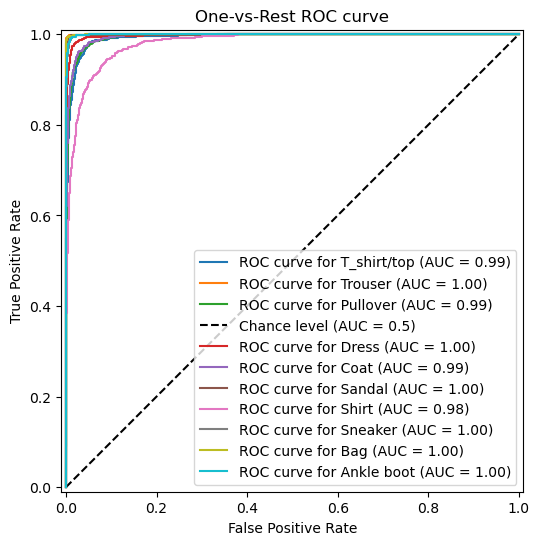

In [17]:
from itertools import cycle
from sklearn.metrics import auc, roc_curve

target_names = [
    "T_shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
y_score = y_pred_prob
n_classes = 10

fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

fig, ax = plt.subplots(figsize=(6, 6))

# colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        # color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curve",
)

In this plot we can see that the 'shirts' category has a significantly worse performance
than any other class. Let's plot a confusion matrix to see this better.


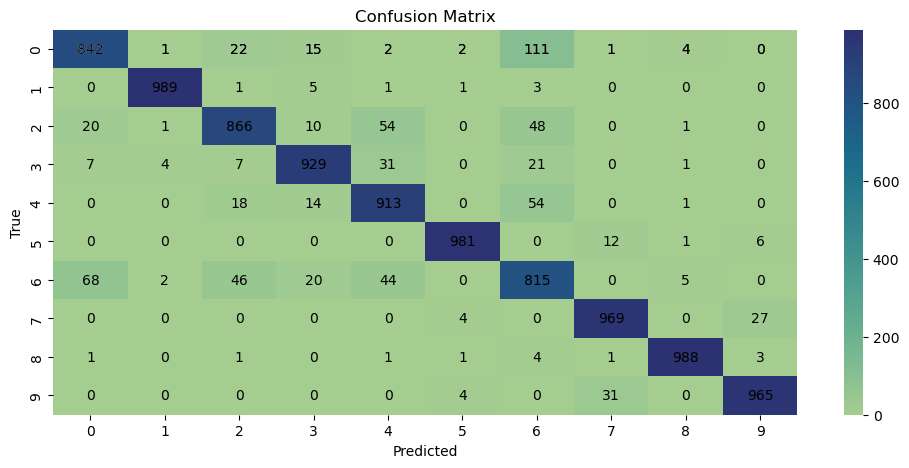

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
cm = confusion_matrix(y_true, y_predicted)
_, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="crest",
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
# Annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j + 0.5, i + 0.5, str(cm[i, j]), ha="center", va="center", color="black"
        )

This plot confirms that most of the wrong predictions are related to class 6 (shirts).
We'll analyze this in detail in the next section.


## Visualizing wrong predictions


Looking at the confusion matrix, it is clear that most of the wrong predictions are related to
class 6 ('shirts').
Let's calculate the exact number.


In [29]:
wrong_predictions = np.sum(cm) - np.sum(np.diag(cm))
wrong_predictions_related_to_shirts = np.sum(cm[6]) - 815 + np.sum(cm[:, 6]) - 815

print(round(100 * wrong_predictions_related_to_shirts / wrong_predictions, 2), "%")

57.34 %


This is not surprising because, as we saw in the EDA, this is the hardest category to identify.
Sometimes, the difference between a shirt and a t-shirt / coat / pullover is only a few pixels.

Furthermore, looking at the confusion matrix one can see that the hardest case for the model
is distinguishing between shirts (class 6) and t-shirts (class 0).
Again, this is not surprising at all, as this is also the hardest case for a human.


Let's visualize some of the cases where the model made the wrong prediction.


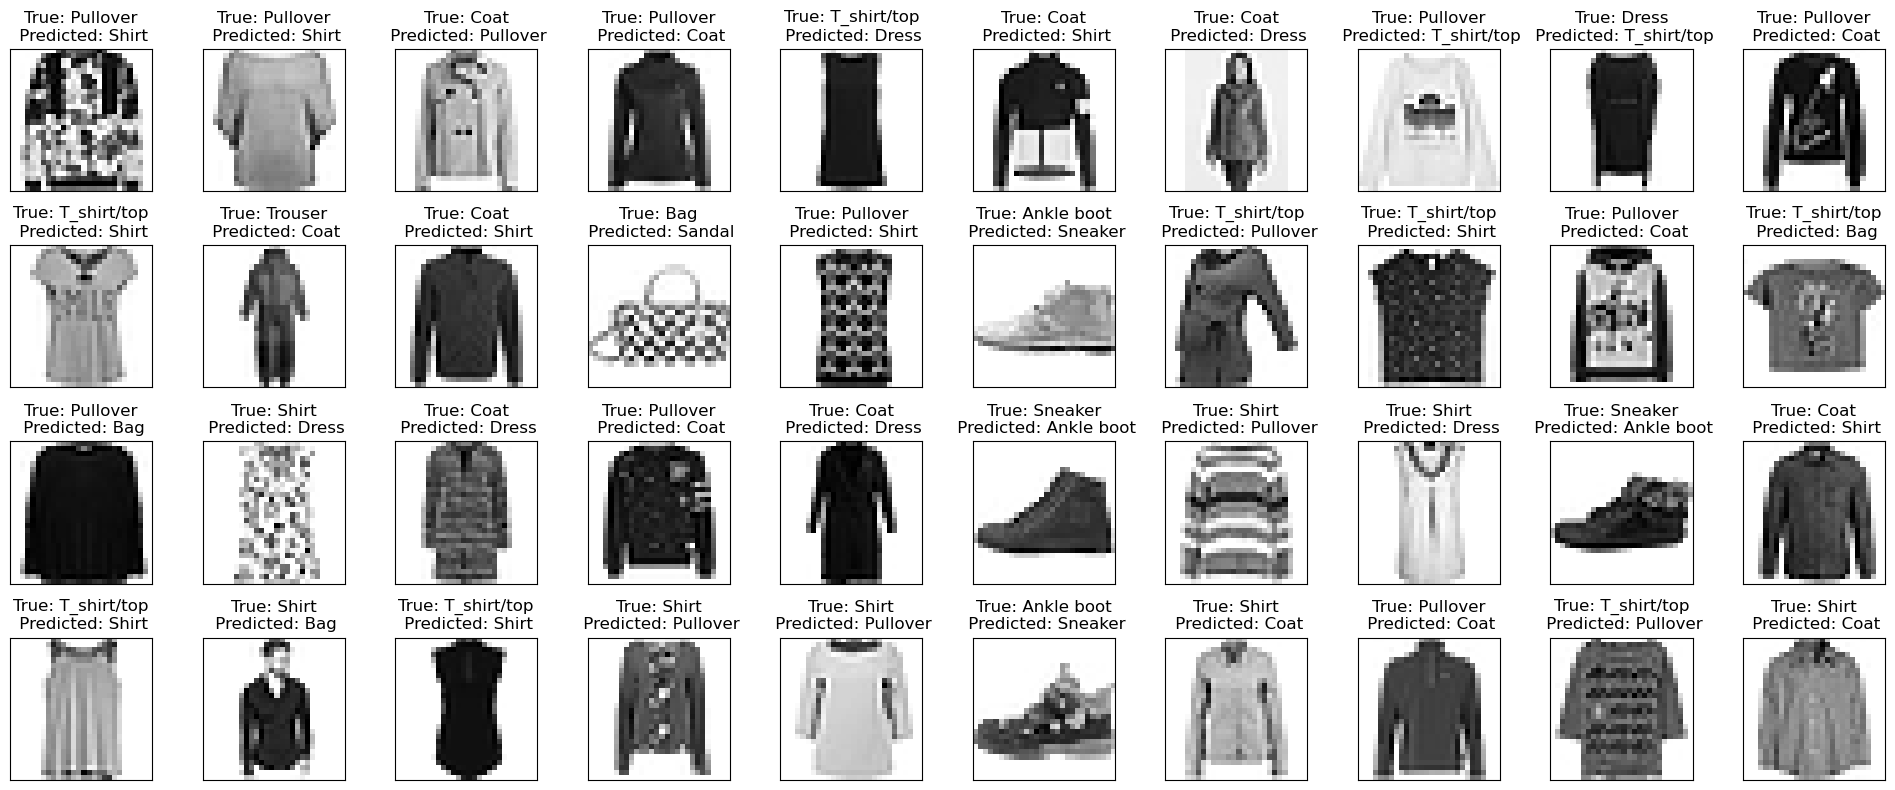

In [44]:
# wrong predictions
images = x_test[y_test != y_predicted]
true_label = y_test[y_test != y_predicted]
predicted_label = y_predicted[y_test != y_predicted]

plt.figure(figsize=(20, 8))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.title(
        f"True: {target_names[int(true_label[i])]}\n Predicted: {target_names[predicted_label[i]]}"
    )
    plt.tight_layout()
plt.show()

Some of these images are very hard to classify, even for a human.
For example, the 2 'shirts' in the center of the bottom row do not look like shirts at all.

However, a human would easily classify most of this images, showing that the model still has
some room for improvement.
